Descripción del Proyecto: Soy analista en una gran tienda en línea. Junto con el departamento de marketing hemos recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. 
Tengo que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

In [70]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats

In [71]:
hypotheses_data = pd.read_csv('/datasets/hypotheses_us.csv', delimiter=';')
orders_data = pd.read_csv('/datasets/orders_us.csv')
visits_data = pd.read_csv('/datasets/visits_us.csv')

In [72]:
#Revisión de datos

print(hypotheses_data.info())
hypotheses_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [73]:
print(orders_data.info())
orders_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [74]:
print(visits_data.info())
visits_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [75]:
#Le damos el tipo de datos correctos a las columnas del dataset 'hypotheses_data'
hypotheses_data['Reach'] = hypotheses_data['Reach'].astype(int)
hypotheses_data['Impact'] = hypotheses_data['Impact'].astype(int)
hypotheses_data['Confidence'] = hypotheses_data['Confidence'].astype(float)
hypotheses_data['Effort'] = hypotheses_data['Effort'].astype(float)

Vamos a limpiar y verificar los datos para asegurarnos de que no hayan errores en los datasets.

In [76]:
# Procesando datos de orders_data
orders_data['date'] = pd.to_datetime(orders_data['date'], format='%Y-%m-%d')
orders_data = orders_data.drop_duplicates()

In [77]:
# Nos aseguramos que la columna 'visitorId' esté en un solo grupo
visitors_group_counts = orders_data.groupby('visitorId')['group'].nunique()
print(visitors_group_counts.head(10))

visitorId
5114589     1
6958315     1
8300375     2
11685486    1
39475350    1
47206413    1
48147722    1
54447517    1
56960363    1
66685450    1
Name: group, dtype: int64


In [78]:
visitors_multiple_groups = visitors_group_counts[visitors_group_counts > 1].index
visitors_multiple_groups

Int64Index([   8300375,  199603092,  232979603,  237748145,  276558944,
             351125977,  393266494,  457167155,  471551937,  477780734,
             818047933,  963407295, 1230306981, 1294878855, 1316129916,
            1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
            1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
            2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
            2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
            2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
            3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
            3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
            3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
            4186807279, 4256040402, 4266935830],
           dtype='int64', name='visitorId')

In [79]:
# Eliminamos los visitantes que estan en los 2 grupos
orders_data = orders_data[~orders_data['visitorId'].isin(visitors_multiple_groups)]

#Verificamos nuevamente
visitors_group_counts2 = orders_data.groupby('visitorId')['group'].nunique()
print(visitors_group_counts2)

visitorId
5114589       1
6958315       1
11685486      1
39475350      1
47206413      1
             ..
4259830713    1
4278982564    1
4279090005    1
4281247801    1
4283872382    1
Name: group, Length: 973, dtype: int64


Ahora podemos verificar que cada 'visitorId' pertenece solo a un grupo

In [80]:
# Procesamos el dataset visit_data
visits_data['date'] = pd.to_datetime(visits_data['date'], format='%Y-%m-%d')
visits_data = visits_data.drop_duplicates()

## Parte 1

Hemos revisado que el archivo hypotheses_us.csv contiene nueve hipótesis sobre cómo aumentar los ingresos de una tienda en línea con Reach, Impact, Confidence y Effort especificados para cada una.

1.0 Aplicar el framework ICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [81]:
hypotheses_data['ICE'] = (hypotheses_data['Impact'] * hypotheses_data['Confidence']) / hypotheses_data['Effort']
print(hypotheses_data[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


El ICE representa la hipótesis 8, 0 y 7 como las más prometedoras.

1.1 Aplicar el framework RICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [82]:
hypotheses_data['RICE'] = (hypotheses_data['Reach'] * hypotheses_data['Impact'] * hypotheses_data['Confidence']) / (hypotheses_data['Effort'])
print(hypotheses_data[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


El RICE represneta que tenemos como hipótesis mas prometedoras: 7, 2 y 0. Se vuelven a repetir la 7 y 0. 

1.3 Mostrar cómo cambia la priorización de hipótesis cuando utilizas RICE en lugar de ICE. Proporcionar una explicación de los cambios.

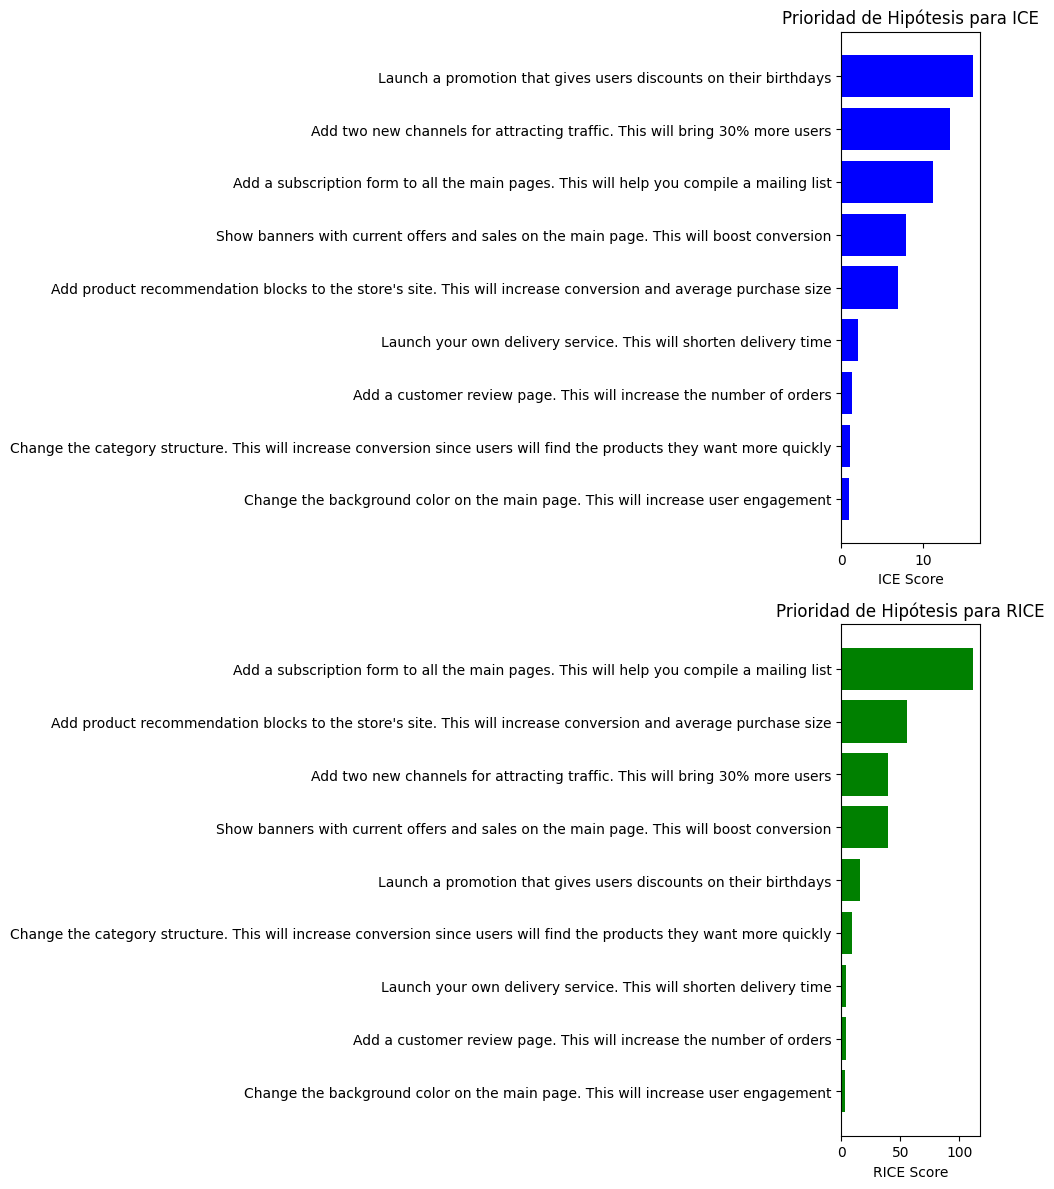

In [83]:
#Les damos valores a los cálculos realizados para poder utilizar variables
ice_sorted = hypotheses_data[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
rice_sorted = hypotheses_data[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

# Mostraremos los gráfico de ICE Y RICE para ver las diferencias.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

#Vamos a Invertir los ejes 'y' de cada gráfico para mostrar el valor en la parte superior y 
#para que el nombre de cada hipótesis pueda ser leido con mayor facilidad

# Gráfico para ICE
axes[0].barh(ice_sorted['Hypothesis'], ice_sorted['ICE'], color='blue')
axes[0].set_title('Prioridad de Hipótesis para ICE')
axes[0].set_xlabel('ICE Score')
axes[0].invert_yaxis()  # Invertimos el eje y para mostrar el valor más alto arriba

#Gráfico para RICE
axes[1].barh(rice_sorted['Hypothesis'], rice_sorted['RICE'], color='green')
axes[1].set_title('Prioridad de Hipótesis para RICE')
axes[1].set_xlabel('RICE Score')
axes[1].invert_yaxis()  # Invertimos el eje y para mostrar el valor más alto arriba

plt.tight_layout()
plt.show()

ICE: Calcula la prioridad de una hipótesis considerando únicamente el 'Impact',  'Confidence' y 'Effort'. Esto quiere decir que se enfoca más en la efectividad que la hipótesis puede analizar y la confianza en ella.

RICE: Incluye 'Reach' en el cálculo, lo que significa que también considera cuántas personas serán impactadas por la hipótesis. Esto puede hacer que una hipótesis con un mayor alcance suba en la priorización.

## Parte 2:  Análisis de test A/B

1. Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [112]:
# Cálculo de los ingresos totales y el núm de compras por grupo
revenue_per_group = orders_data.groupby('group')['revenue'].sum().reset_index()
revenue_per_group.columns = ['group', 'total_revenue']
print(revenue_per_group)

  group  total_revenue
0     A        53212.0
1     B        79651.2


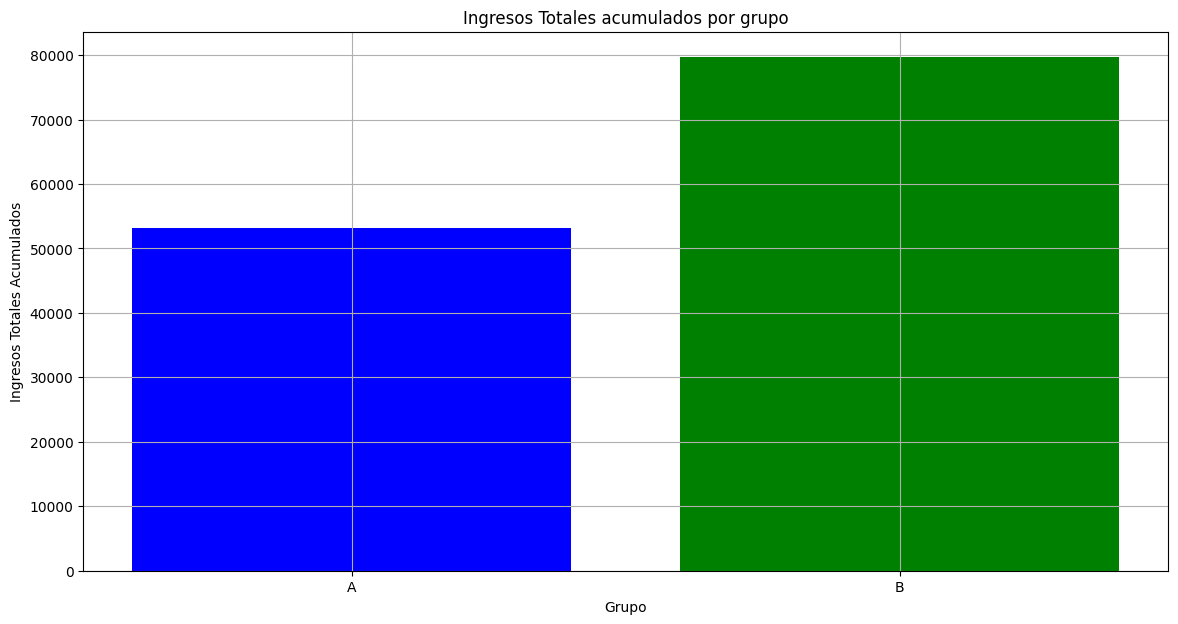

In [85]:
# Gráfico de los ingresos totales acumulados por grupo
plt.figure(figsize=(14, 7))
plt.bar(revenue_per_group['group'], revenue_per_group['total_revenue'], color=['blue', 'green'])
plt.title('Ingresos Totales acumulados por grupo')
plt.xlabel('Grupo')
plt.ylabel('Ingresos Totales Acumulados')
plt.grid(True)
plt.show()

Este gráfico representa los ingresos totales acumulados del grupo A(azul) y B(verde) el Grupo B tiene ingresos significativamente más altos que el grupo A con 79651.2 Ingresos acumulados y el A con 53212.0 Ingresos acumulados.

2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

In [86]:
# Vamos a darle el tipo de datos correcto a las columnas 'date' de cada dataset

# Vamos a visualizar los datos de cada dataset
print(orders_data.head())
print(visits_data.head())

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B
5      182168103   935554773 2019-08-15     35.0     B
        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


In [87]:
# Creando una matriz con valores únicos de parejas date-group
datesGroups = orders_data[['date', 'group']].drop_duplicates()
print(datesGroups.head())

         date group
0  2019-08-15     B
7  2019-08-15     A
45 2019-08-16     A
47 2019-08-16     B
55 2019-08-01     A


In [113]:
#Aplicamos métodos a cada fila del DataFrame y ordenamos los resultamos por columnas 'date' y 'group'
#Cálculo de los resultados y los almacenamos en la tabla 'ordersAggregated' y 'visitorsAggregated'
ordersAggregated = datesGroups.apply(lambda x: orders_data[np.logical_and(orders_data['date'] <= x['date'], orders_data['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'transactionId': pd.Series.nunique, 'visitorId': pd.Series.nunique, 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])
visitorsAggregated = datesGroups.apply(lambda x: visits_data[np.logical_and(visits_data['date'] <= x['date'], visits_data['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1).sort_values(by=['date', 'group'])

print(ordersAggregated.head())
print(visitorsAggregated.head())

          date group  transactionId  visitorId  revenue
55  2019-08-01     A             23         19   2266.6
66  2019-08-01     B             17         17    967.2
175 2019-08-02     A             42         36   3734.9
173 2019-08-02     B             40         39   3535.3
291 2019-08-03     A             66         60   5550.1
          date group  visits
55  2019-08-01     A     719
66  2019-08-01     B     713
175 2019-08-02     A    1338
173 2019-08-02     B    1294
291 2019-08-03     A    1845


In [89]:
#Fusionamos las 2 tablas y damos a sus columnas nombres descriptivos:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   2266.6       719
1 2019-08-01     B      17      17    967.2       713
2 2019-08-02     A      42      36   3734.9      1338
3 2019-08-02     B      40      39   3535.3      1294
4 2019-08-03     A      66      60   5550.1      1845


In [90]:
#Dataframe con pedidos acumulados e ingresos por grupo
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]
print("Resultados para el grupo A:")
print(cumulativeRevenueA.sum())
print("Resultados para el grupo B:")
print(cumulativeRevenueB.sum())

Resultados para el grupo A:
revenue    840331.0
orders       7904.0
dtype: float64
Resultados para el grupo B:
revenue    1216292.8
orders        9038.0
dtype: float64


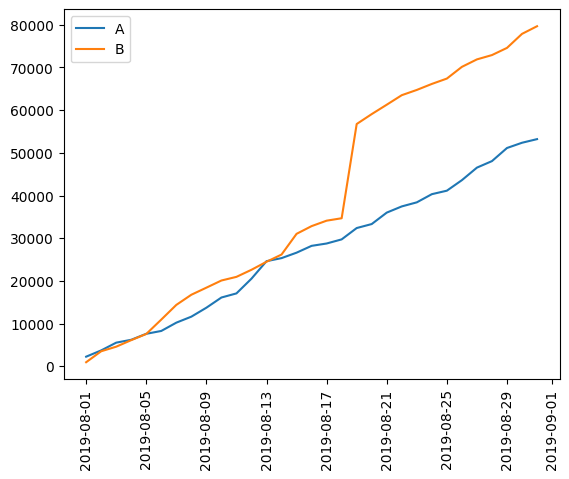

In [91]:
#Gráfico de ingresos del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
#Gráfico de ingresos del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=90)
plt.legend()

Podemos ver que los ingresos aumentan constantemente en cada grupo tal y como mostramos en el gráfico anterior el grupo B tiene mayores ingresos, el grupo B tiene un pico de de ingresos muy alto despues del '2019-08-21'. 

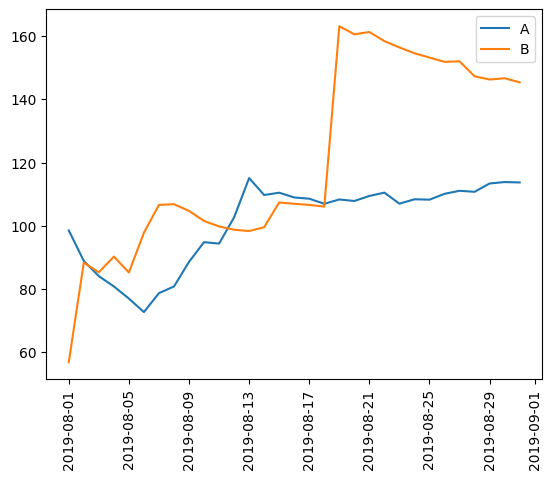

In [92]:
# Vamos a trazar el tamaño promedio de pedido/compra por grupo es la division de los ingresos acumulados entre el número acumulado de pedidos
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.legend()

Tenemos picos altos y bajos en ambos grupos, El grupo A tiene un pico de bajada y luego un pico de subida al final tiende a estabilizarse, el grupo B tiende subir luego tiene gran pico alto y al final tiende a bajar. Vamos a encontrar el verdadero tamaño promedio con la diferencia relativa.

3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.

In [93]:
#Reunión de datos en un dataframe
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
print(mergedCumulativeRevenue.head())

        date  revenueA  ordersA  revenueB  ordersB
0 2019-08-01    2266.6       23     967.2       17
1 2019-08-02    3734.9       42    3535.3       40
2 2019-08-03    5550.1       66    4606.9       54
3 2019-08-04    6225.6       77    6138.5       68
4 2019-08-05    7623.6       99    7587.8       89


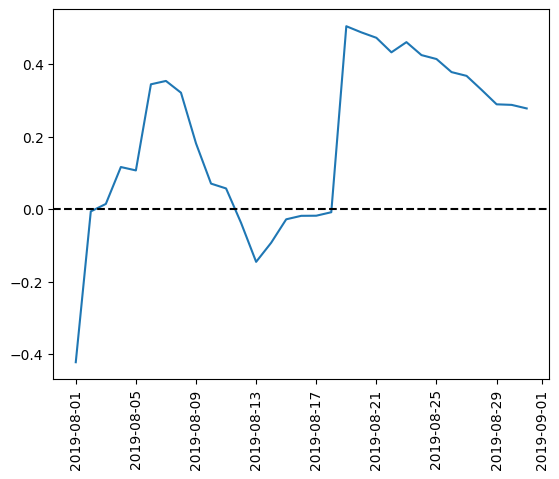

In [94]:
#Gráfico de diferencia relativa para los tamaños de compra promedio
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=90)

#Agregamos la linea punteada en el eje X
plt.axhline(y=0, color='black', linestyle='--')

En varios puntos, la diferencia entre los segmentos más aumenta que disminuye, esto significa que tenemos pedidos grandes y valores atípicos.

4. Calcularemos la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día y Representaremos gráficamente las tasas de conversión diarias de los dos grupos y describiremos la diferencia.

In [95]:
#Cálculo de tasa de conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
print(cumulativeData['conversion'].head())

0    0.031989
1    0.023843
2    0.031390
3    0.030912
4    0.035772
Name: conversion, dtype: float64


In [96]:
#Seleccionamos datos del grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
print('Datos grupo A')
print(cumulativeDataA.head())

#Seleccionamos datos del grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
print('\nDatos grupo B')
print(cumulativeDataB.head())

Datos grupo A
        date group  orders  buyers  revenue  visitors  conversion
0 2019-08-01     A      23      19   2266.6       719    0.031989
2 2019-08-02     A      42      36   3734.9      1338    0.031390
4 2019-08-03     A      66      60   5550.1      1845    0.035772
6 2019-08-04     A      77      71   6225.6      2562    0.030055
8 2019-08-05     A      99      92   7623.6      3318    0.029837

Datos grupo B
        date group  orders  buyers  revenue  visitors  conversion
1 2019-08-01     B      17      17    967.2       713    0.023843
3 2019-08-02     B      40      39   3535.3      1294    0.030912
5 2019-08-03     B      54      53   4606.9      1803    0.029950
7 2019-08-04     B      68      66   6138.5      2573    0.026428
9 2019-08-05     B      89      87   7587.8      3280    0.027134


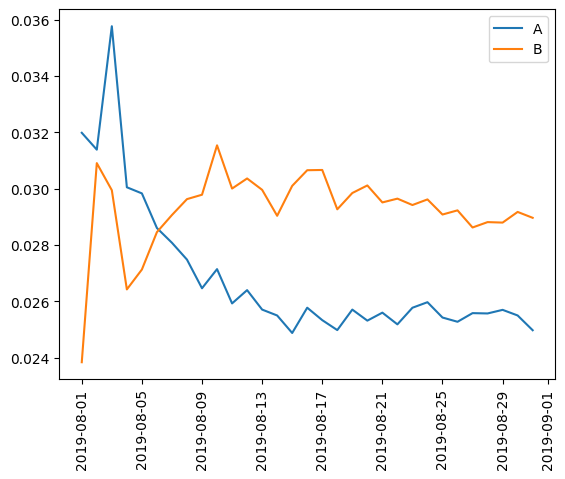

In [97]:
#Trazo de gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=90)
plt.legend()

Tenemos gráficos simétricos con respecto a que ambos grupos comienzan con un pico alto, el grupo A va teniendo una disminución en su tasa de conversión y luego se estabiliza, con respecto grupo B la tasa de conversión va mejorando  y se estabiliza con una pequeña disminución al final.

In [98]:
#Cálculo de la diferencia relativa para las tasas de conversión acumuladas
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


No handles with labels found to put in legend.


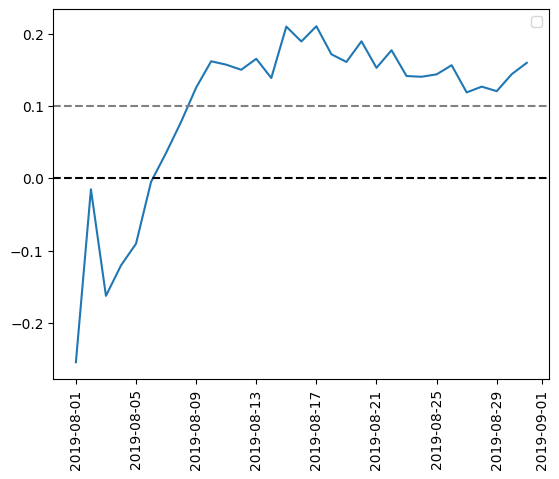

In [99]:
#Gráfico de la diferencia relativa para las tasas de conversión acumuladas
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xticks(rotation=90)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

Con respecto al gráfico, el grupo B fue el líder desde un principio estabilizándose con un 10% más que el grupo A, pero el índice de conversión aún no es estable y todavía no se pueden tener conclusiones claras

5. Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

In [114]:
#Vamos a buscar el número de pedidos por usuario
ordersByUsers = (
    orders_data.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


Hay usuarios con 3 y 2 pedidos. Es el promedio que habitualmente hacen en una semana.

(array([937.,   0.,   0.,   0.,   0.,  29.,   0.,   0.,   0.,   7.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

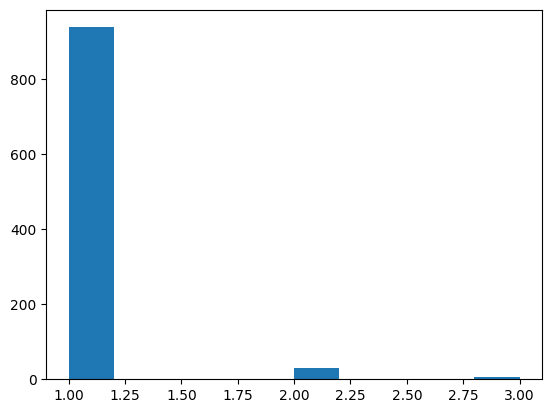

In [116]:
plt.hist(ordersByUsers['orders'])

La mayoría de los clientes hicieron solo un pedido. Sim embargo, una parte significativa hizo de dos a tres cada uno.

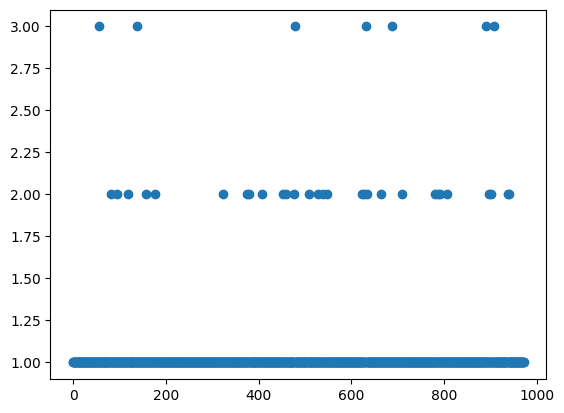

In [101]:
#Gráfico de dispersion del número de pedidos por usuario
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

Las conclusiones que tenemos es que hay muchos usuarios con 1, 2 y 3 pedidos. No sabemos la proporción exacta ya que todavía no sabemos si considerarlos como anomalías.

6.Calcularemos los percentiles 95 y 99 para el número de pedidos por usuario y  Definiremos el punto en el cual un punto de datos se convierte en una anomalía.

In [102]:
#Cálculo de percentiles 95 y 99 para el número de pedidos por usuario
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


No más del 5% de los usuarios realizan más de 1 pedido

No más del 1% de los usuarios realizan más de 2 pedidos

Por lo tanto es razonable establecer como 2 pedidos por usuario como límite inferior para el número de pedidos. Y de acuerdo a este límite filtrar las anomalías.

7. Trazaremos un gráfico de dispersión de los precios de los pedidos.

In [103]:
#Revisamos los datos
print(orders_data.head(10))

    transactionId   visitorId       date  revenue group
0      3667963787  3312258926 2019-08-15     30.4     B
1      2804400009  3642806036 2019-08-15     15.2     B
3      3797467345  1196621759 2019-08-15    155.1     B
4      2282983706  2322279887 2019-08-15     40.5     B
5       182168103   935554773 2019-08-15     35.0     B
6       398296753  2900797465 2019-08-15     30.6     B
7      2626614568    78758296 2019-08-15     20.1     A
8      1576988021   295230930 2019-08-15    215.9     A
9      1506739906  1882260405 2019-08-15     30.5     B
10     3649131742   879864040 2019-08-15     65.7     A


Dentro de los 10 primeros pedidos tenemos filas que varían entre 215.9 y 10.2

In [104]:
#El precio de pedido mas grande y el más pequeño
max_revenue = orders_data['revenue'].max()
min_revenue = orders_data['revenue'].min()
print(f"El revenue más alto del dataset es: {max_revenue}")
print(f"El revenue más bajo del dataset es: {min_revenue}")

El revenue más alto del dataset es: 19920.4
El revenue más bajo del dataset es: 5.0


Si un pedido tan grande entra en uno de los grupps de prueba, inmediatamente distorcionará los resultados.

(array([1.014e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.000000e+00, 1.996540e+03, 3.988080e+03, 5.979620e+03,
        7.971160e+03, 9.962700e+03, 1.195424e+04, 1.394578e+04,
        1.593732e+04, 1.792886e+04, 1.992040e+04]),
 <BarContainer object of 10 artists>)

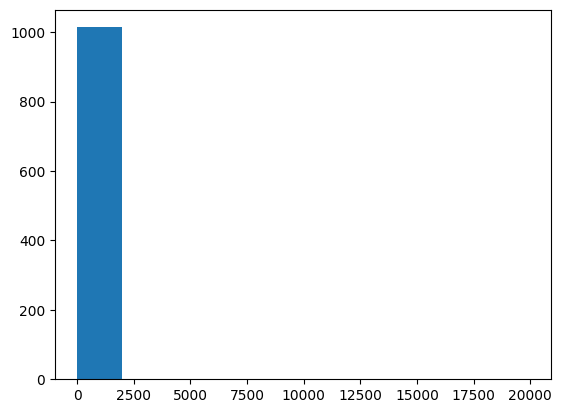

In [105]:
#Análisis del histograma de distribución de precios de pedidos:
plt.hist(orders_data['revenue'])

El hisograma nos muestra que definitivamente, el dataset contiene pedidos que cuestan mas de $1200, donde la mayoría de los pedidos son más pequeños.

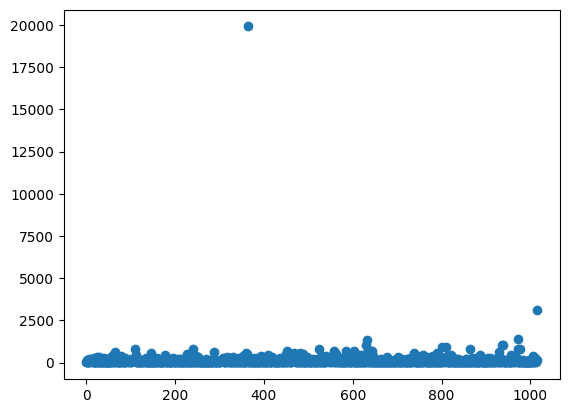

In [106]:
#Gráfico de disperción
x_values = pd.Series(range(0, len(orders_data['revenue'])))
plt.scatter(x_values, orders_data['revenue'])

Tal como esperamos, tenemos 2 pedidos grandes, uno de ellos es completamente grande, tenemos que establecer un límite para pedidos anormales.

8. Cálculo los percentiles 95 y 99 de los precios de los pedidos y Definiremos el punto en el cual un punto de datos se convierte en una anomalía.

In [107]:
print(np.percentile(orders_data['revenue'], [95, 99]))

[414.275 830.3  ]


No más del 5% de los pedidos cuestan más de $414.28

No más del 1% de los pedidos cuestan más de $830.3

Por lo tanto es razonable establecer $830 como precio por pedido promedio por usuario como límite inferior para el número de pedidos. Y de acuerdo a este límite filtrar las anomalías.

9. Encontraremos la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [108]:
#Cálculo de la significancia estadística de la diferencia de la diferencia en la conversión entre los grupos
ordersByUsersA = orders_data[orders_data['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})     
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders_data[orders_data['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [109]:
#Vamos a crear un objeto pd.Series con la longitud requerida y
#Declarar las variables sampleA y sampleB con usuarios de diferentes grupos
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(visits_data[visits_data['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(visits_data[visits_data['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

In [110]:
#Encontramos la tasa de conversión para ambos grupos
print("{0: .3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0: .3f}".format(sampleB.mean()/sampleA.mean()-1))

 0.011
 0.160


Conclusión: La primera fila de salida nos da un valor de 0.011, que es menor que 0.05. Entonces rechazamos la hipótesis nula ya que existe una diferencia estadísticamente significativa en la conversión entre los grupos. La tasa de conversión del grupo B es un 16% mayor que la del grupo A, indicando que el grupo B tiene un rendimiento mejor en términos de conversión en comparación con el grupo A.

10. Encontraremos la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [111]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders_data[orders_data['group']=='A']['revenue'], orders_data[orders_data['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders_data[orders_data['group']=='B']['revenue'].mean() / orders_data[orders_data['group']=='A']['revenue'].mean()-1))

0.862
0.278


El valor es notablemente superior a 0.05 por lo que no hay motivo para rechazar la hipótesis nula y concluir que el tamaño medio de los pedidos difiere entre los grupos. El tamaño promedio de pedido del grupo B es un 27.8% mayor que el tamaño promedio de pedido del grupo A, aunque la diferencia parece grande, no podemos estar seguros de que no sea simplemente el resultado de la variabilidad aleatoria en los datos.

11. Encontraremos la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. 

In [117]:
#Vamos a filtrar el número total de usuarios anómalos
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']], axis = 0)
usersWithExpensiveOrders = orders_data[orders_data['revenue'] > 830]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
(12,)


En total tenemos 12 usuarios anómalos

In [120]:
#Preparación de muestras del número de pedidos por usuario para cada grupo
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visits_data[visits_data['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visits_data[visits_data['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

In [122]:
#Aplicamos criterio estadístico de Mann-Whitney a las muestras
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean()-1))

0.009
0.167


Los resultados son muy parecidos a los anteriores, casi no cambiaron.

12. Encontremos la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. 

In [123]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders_data[np.logical_and(
        orders_data['group']=='A', 
        np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'], 
    orders_data[np.logical_and(
        orders_data['group']=='B', 
        np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders_data[np.logical_and(orders_data['group']=='B', np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders_data[np.logical_and(
        orders_data['group']=='A',
        np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.988
-0.014


El valor p aumentó y ahora la diferencia entre los segmentos es del 1.4% en lugar de 27.8%

Aunque las conclusiones generales de la prueba no cambiaron, este análisis demuestra como las anomalías pueden cambiar y afectar los resultados de la prueba A/B.

13. Tomaremos una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Para la prueba, considera a uno de los grupos como líder. 2. Para la prueba, concluye que no hay diferencia entre los grupos. 3. Continúa la prueba.

1. De acuerdo a la Prueba de Mann-Whitney U para la conversión:
Valor p = 0.009:
Este valor p es menor que el nivel de significancia (0.05), lo que indica que hay una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B después de filtrar los datos.
Diferencia relativa = 0.167:
La tasa de conversión del grupo B es un 16.7% mayor que la del grupo A.

2. De acuerdo a la Prueba de Mann-Whitney U para el tamaño promedio de pedido:
Valor p = 0.988:
Este valor p es mayor que el nivel de significancia (0.05), lo que indica que no hay una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos A y B después de filtrar los datos.
Diferencia relativa = -0.014:
La diferencia relativa muestra que el tamaño promedio de pedido del grupo B es un 1.4% menor que el del grupo A, lo cual es prácticamente insignificante.

3. Desición: Para la tasa de conversión:

Dado que hay una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B, con el grupo B mostrando una mejora del 16.7%, se puede concluir que el grupo B es el líder en términos de conversión.


Para el tamaño promedio de pedido:

Dado que no hay una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos A y B, y la diferencia relativa es prácticamente insignificante, se puede concluir que no hay diferencia significativa en el tamaño promedio de pedido entre los grupos.

CONSLUSION FINAL:
Para la prueba, se considera al grupo B como líder en términos de tasa de conversión, pero concluye que no hay diferencia significativa entre los grupos en cuanto al tamaño promedio de pedido.